# Assigment 8
# Development of a tracking filter of a moving object when measurements and motion models are in different coordinate systems

## Team 6: Berman Vladimir, Dronova Maria, Bazhenov Artem, Skoltech, October, 2022

## Initialisation of libraries 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Setting functions

### Generating true trajectory Xi

In [2]:
def generate_X(x0, y0, Vx, Vy, T, N):
    arrx = np.zeros(N)
    arry = np.zeros(N)
    arrVx = np.zeros(N)
    arrVy = np.zeros(N)
    X = np.zeros([N, 4])
    arrx[0] = x0
    arry[0] = y0
    arrVx[0] = Vx
    arrVy[0] = Vy
    for i in range(1, N):
        arrx[i] = arrx[i - 1] + arrVx[i - 1] * T
        arry[i] = arry[i - 1] + arrVy[i - 1] * T
        arrVx[i] = arrVx[i - 1]
        arrVy[i] = arrVy[i - 1]
    X[:, 0] = arrx
    X[:, 1] = arrVx
    X[:, 2] = arry
    X[:, 3] = arrVx
    return X

### Generating true radius D and azimuth Beta

In [3]:
def generate_D(x, y):
    D = np.zeros([len(x), 2])
    for i in range(len(x)):
        D[i, 0] = (x[i] ** 2 + y[i] ** 2) ** 0.5
        D[i, 1] = np.arctan(x[i] / y[i])
    return D

### Generating measurement noises Eta

In [4]:
def generate_eta(sigma_eta_D, sigma_eta_b, N):
    eta = np.zeros([N, 2])
    eta[:, 0] = np.random.normal(0, sigma_eta_D, N)
    eta[:, 1] = np.random.normal(0, sigma_eta_b, N)
    return eta

### Generating measurements z

In [5]:
def trans_to_cart(Dm):
    Zc = np.zeros([len(Dm), 2])
    Zc[:, 0] = Dm[:, 0] * np.sin(Dm[:, 1])
    Zc[:, 1] = Dm[:, 0] * np.cos(Dm[:, 1])
    return Zc

def generate_z(x0, y0, Vx, Vy, T, N, sigma_eta_D, sigma_eta_b):
    X = generate_X(x0, y0, Vx, Vy, T, N)
    D = generate_D(X[:, 0], X[:, 2])
    sigma_eta_D, sigma_eta_b = 20, 0.02
    eta = generate_eta(sigma_eta_D, sigma_eta_b, N)
    Dm = D + eta
    Zc = trans_to_cart(Dm)
    return Zc, Dm, generate_R(Dm, sigma_eta_D, sigma_eta_b)

### Generating covariance matrix R

In [6]:
def generate_R(Dm, sigma_eta_D, sigma_eta_b):
    R = np.zeros([len(Dm), 2, 2])
    for i in range(len(R)):
        R[i, 0, 0] = (np.sin(Dm[i, 1]) * sigma_eta_D) ** 2 + (Dm[i, 0] * np.cos(Dm[i, 1]) * sigma_eta_b) ** 2
        R[i, 0, 1] = np.sin(Dm[i, 1]) * np.cos(Dm[i, 1]) * (sigma_eta_D ** 2 - (Dm[i, 0] * sigma_eta_b) ** 2)
        R[i, 1, 0] = R[i, 0, 1]
        R[i, 1, 1] = (np.cos(Dm[i, 1]) * sigma_eta_D) ** 2 + (Dm[i, 0] * np.sin(Dm[i, 1]) * sigma_eta_b) ** 2
    return R

### Constructing Kalman filter

In [7]:
def kalman_filt(z, X0, P0, F, Q, R, H):
    Xii = np.zeros([len(z), len(H[0])])
    Xiin1 = np.zeros([len(z), len(H[0])])
    Piin1 = np.zeros([len(z), len(H[0]), len(H[0])])
    Pii = np.zeros([len(z), len(H[0]), len(H[0])])
    K = np.zeros([len(z), len(H[0]), len(z[0])])
    Xii[0] = X0
    Xiin1[0] = X0
    Pii[0] = P0
    Piin1[0] = P0
    for i in range(1, len(X)):
        Xiin1[i] = (F.dot(Xii[i - 1].reshape(len(H[0]), 1))).reshape(1, len(H[0]))
        Piin1[i] = (F.dot(Pii[i - 1])).dot(F.transpose()) + Q
        
        K[i] = (Piin1[i].dot(H.transpose())).dot(np.linalg.inv((H.dot(Piin1[i])).dot(H.transpose()) + R[i]))
        
        Xii[i] = Xiin1[i] + K[i].dot(z[i] - H.dot(Xiin1[i]))
        Pii[i] = (np.identity(len(H[0])) - K[i].dot(H)).dot(Piin1[i])
        
    return Xii, generate_D(Xii[:, 0], Xii[:, 2]), generate_D(Xiin1[:, 0], Xiin1[:, 2]), Pii, Piin1, K

### Calculating errors

In [8]:
def prob(x0, y0, Vx, Vy, T, N, sigma_eta_D, sigma_eta_b, X0, P0, F, Q, H):
    
    err_D = np.zeros([500, N - 3, 2])
    err_D_pred = np.zeros([500, N - 3, 2])
    for i in range(500):
        
        X = generate_X(x0, y0, Vx, Vy, T, N)
        D = generate_D(X[:, 0], X[:, 2])
        
        eta = generate_eta(sigma_eta_D, sigma_eta_b, N)
        Dm = D + eta
        
        Zc = trans_to_cart(Dm)
        
        R = generate_R(Dm, sigma_eta_D, sigma_eta_b)
        
        X_filt = kalman_filt(Zc, X0, P0, F, Q, R, H)
        
        err_D[i, :, 0] = np.array(D[3:, 0] - X_filt[1][3:, 0]) ** 2 # true filtration error for 1 trajectory for D
        err_D[i, :, 1] = np.array(D[3:, 1] - X_filt[1][3:, 1]) ** 2  # true filtration error for 1 trajectory for Beta
        err_D_pred[i, :, 0] = np.array(D[3:, 0] - X_filt[2][3:, 0]) ** 2 # true prediction error for 1 trajectory for D
        err_D_pred[i, :, 1] = np.array(D[3:, 1] - X_filt[2][3:, 1]) ** 2 # true prediction error for 1 trajectory for Beta
        
    final_err = np.zeros([N - 3, 4])
    for i in range(N - 3):
        final_err[i] = np.array([(np.mean(err_D[:, i, 0])) ** 0.5, (np.mean(err_D[:, i, 1])) ** 0.5,
                                (np.mean(err_D_pred[:, i, 0])) ** 0.5, (np.mean(err_D_pred[:, i, 1])) ** 0.5])
    return final_err

### Calculating condition number of measurement error covariance matrix R

In [9]:
def condition_number(Dm, sigma_eta_D, sigma_eta_b):
    cond = np.zeros(len(Dm))
    for i in range(len(Dm)):
        if sigma_eta_D ** 2 > (Dm[i, 0] * sigma_eta_b) ** 2:
            cond[i] = (sigma_eta_D ** 2) / ((Dm[i, 0] * sigma_eta_b) ** 2)
        else:
            cond[i] = ((Dm[i, 0] * sigma_eta_b) ** 2) / (sigma_eta_D ** 2)
    return cond

### 1. Generating a true trajectory X of an object that moves uniformly

In [10]:
N = 26
T = 2
Vx = -50
Vy = -45
x0 = 13500 / (2 ** 0.5)
y0 = 13500 / (2 ** 0.5)
X = generate_X(x0, y0, Vx, Vy, T, N)

### 2. Generating true values of range D and azimuth Beta

In [11]:
D = generate_D(X[:, 0], X[:, 2])

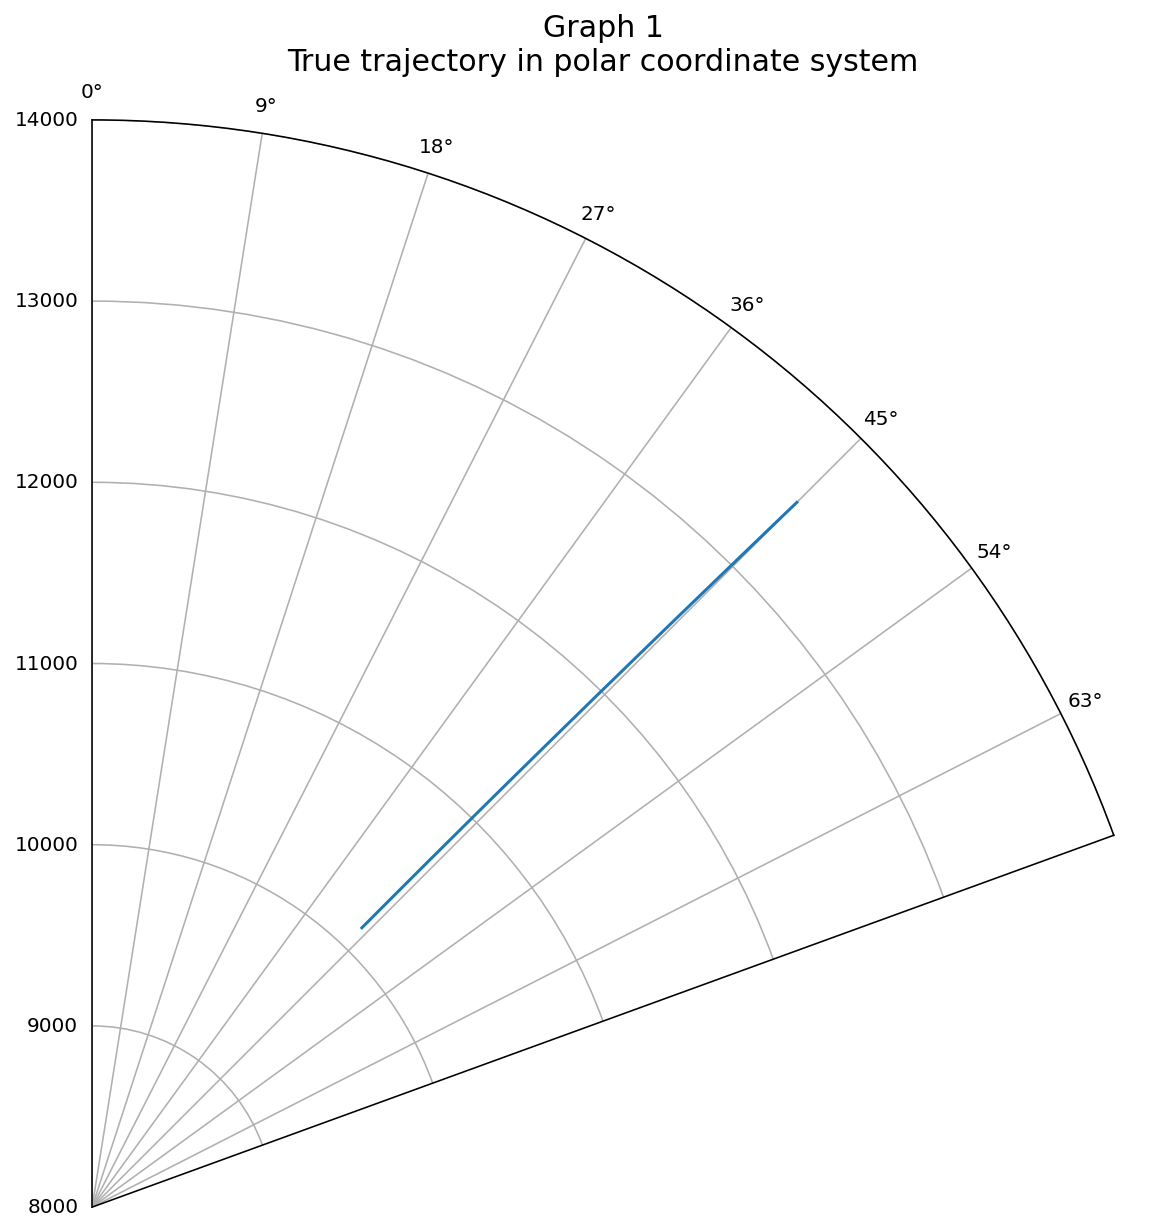

Text(0.5, 1.0, 'Graph 2\nTrue trajectory in cartesian system')

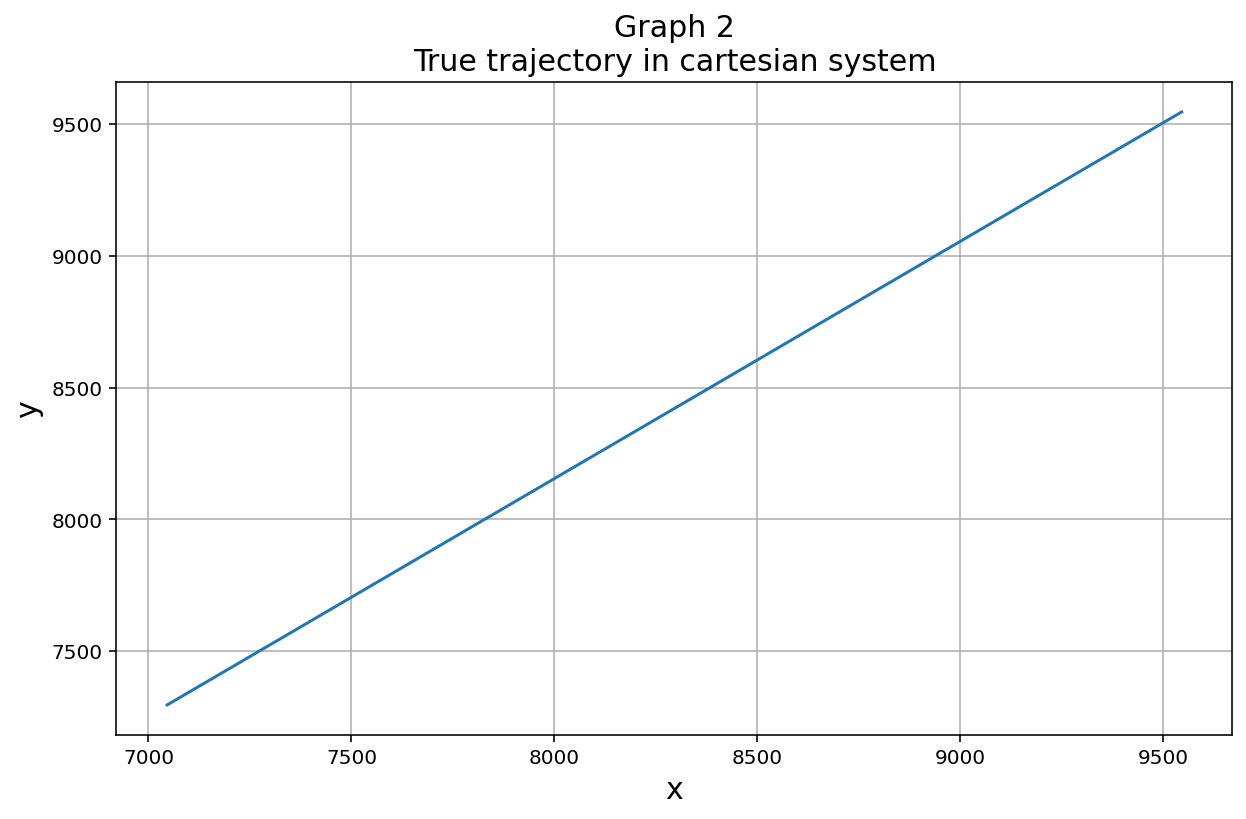

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.polar(D[:, 1], D[:, 0])
ax.set_rlim(8000,14000)
ax.set_xlim([0*(np.pi/180),70*(np.pi/180)])
plt.title('Graph 1\nTrue trajectory in polar coordinate system', fontsize=15)

plt.show()
plt.figure(figsize = (10, 6))
plt.plot(X[:, 0], X[:, 2])
plt.grid()
plt.ylabel('y', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.title('Graph 2\nTrue trajectory in cartesian system', fontsize=15)

### Generating measurements Dm and Betam

In [13]:
sigma_eta_D, sigma_eta_b = 20, 0.02
eta = generate_eta(sigma_eta_D, sigma_eta_b, N)
Dm = D + eta

Text(0.5, 1.0, 'Graph 3\nMeasurements in polar coordinate system')

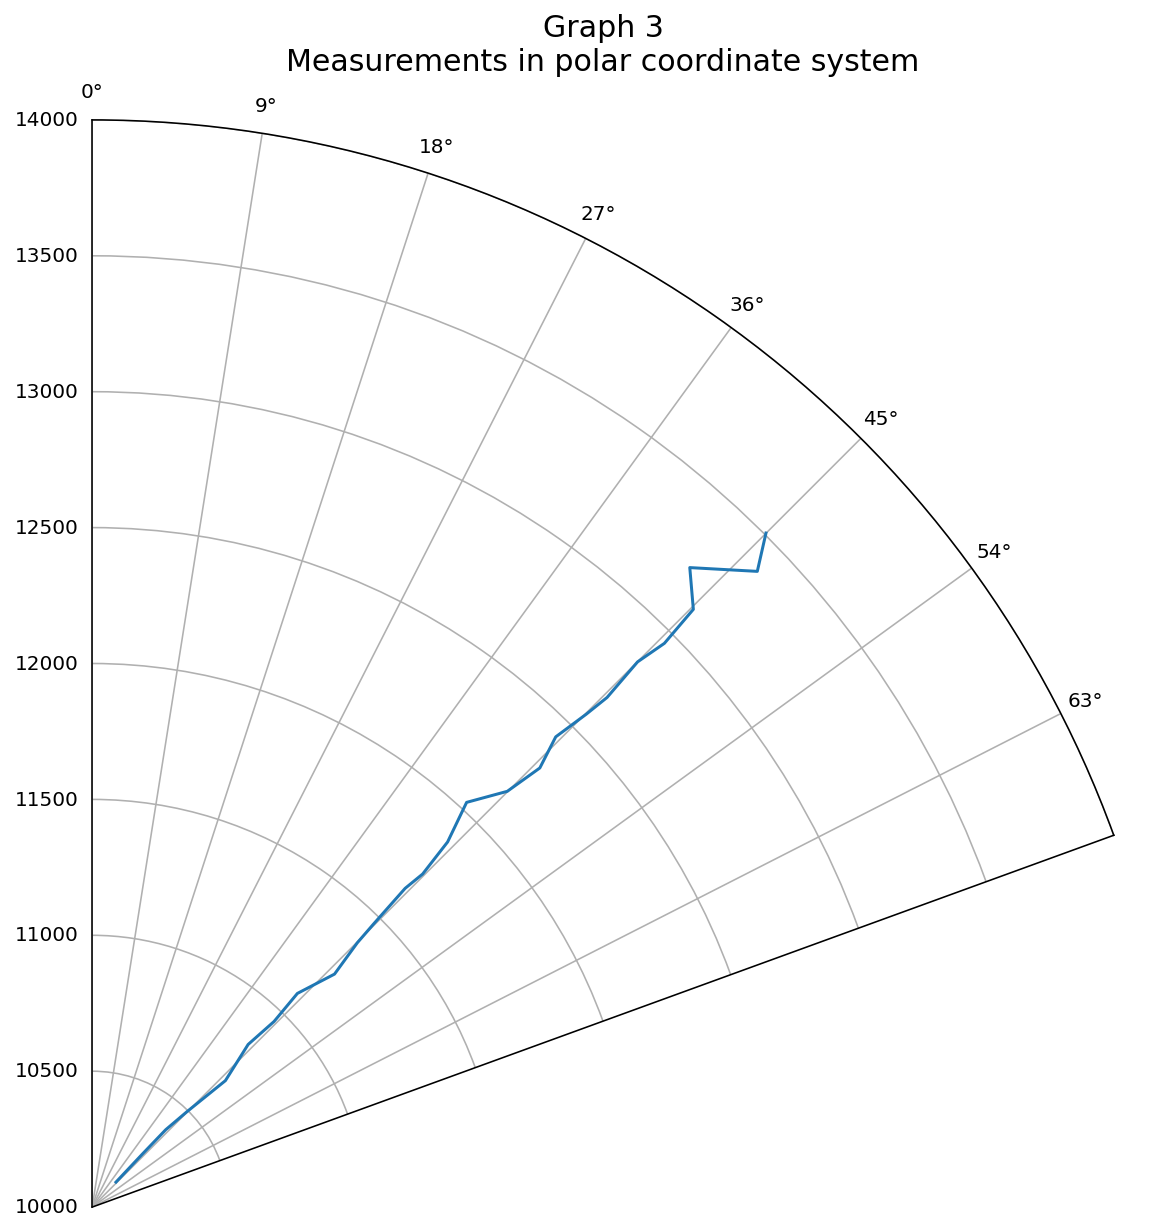

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.polar(Dm[:, 1], Dm[:, 0])
ax.set_rlim(10000,14000)
ax.set_xlim([0*(np.pi/180),70*(np.pi/180)])
plt.title('Graph 3\nMeasurements in polar coordinate system', fontsize=15)

### 4, 5. Transforming polar coordinates Dm and Betam to Cartesian ones and getting pseudo-measurements of coordinates x and y, creating the measurement vector z

Text(0.5, 1.0, 'Graph 4\nPseudo-measurements in cartesian system')

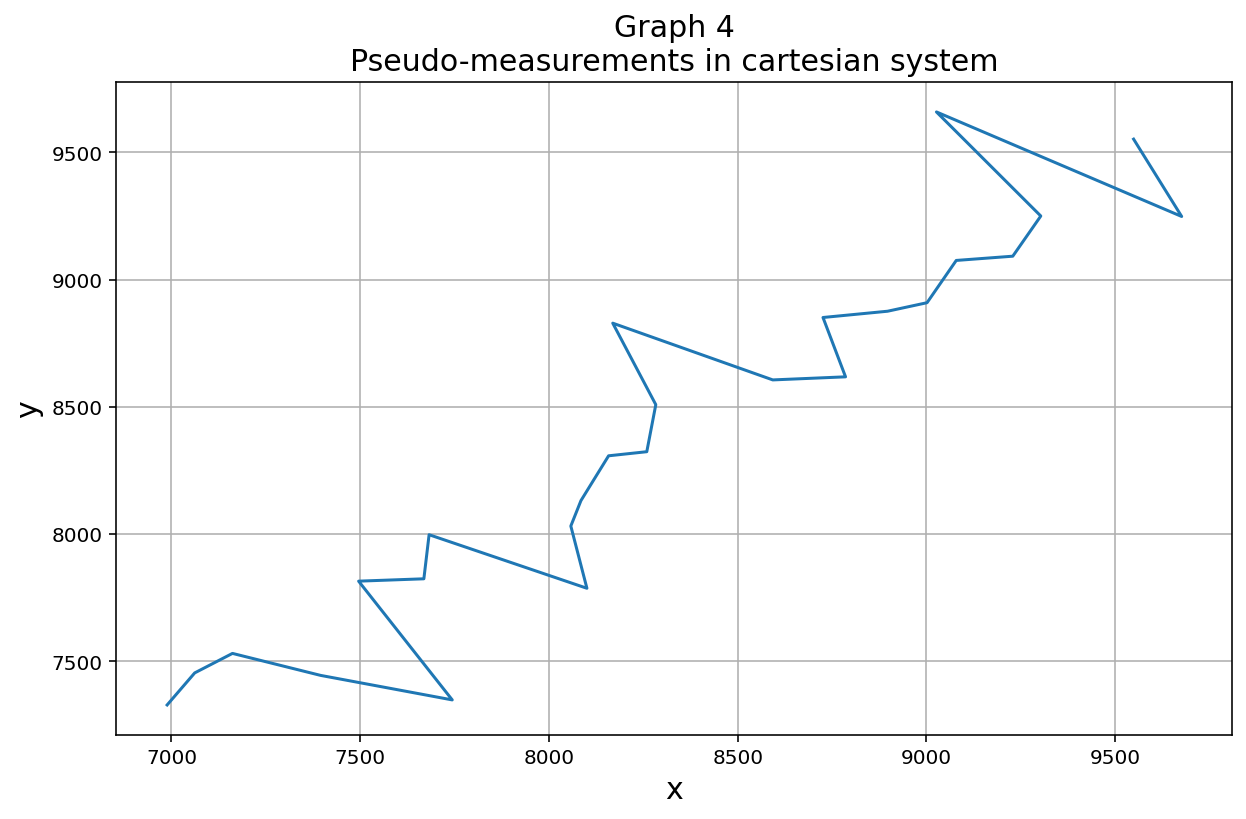

In [15]:
plt.figure(figsize = (10, 6))
Zc = trans_to_cart(Dm)
plt.plot(Zc[:, 0], Zc[:, 1])
plt.grid()
plt.ylabel('y', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.title('Graph 4\nPseudo-measurements in cartesian system', fontsize=15)

### 6. Initial conditions for Kalman filter algorithm

In [16]:
# Initial filtered estimate of state vector X0,0
X0 = np.array([40000, -20, 40000, -20])
# Initial filtration error covariance matrix  P0,0
P0 = np.array([[10 ** 10, 0, 0, 0],
               [0, 10 ** 10, 0, 0],
               [0, 0, 10 ** 10, 0],
               [0, 0, 0, 10 ** 10]])

### 7. Creating the transition matrix F and observation matrix H

In [17]:
F = np.array([[1, T, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, T],
              [0, 0, 0, 1]])
H = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])

Q = 0

### 8. Creating the measurement error covariance matrix Ri

In [18]:
R = generate_R(Dm, sigma_eta_D, sigma_eta_b)

### 9. Applying Kalman filter algorithm 

In [19]:
X_filt = kalman_filt(Zc, X0, P0, F, Q, R, H)

Text(0.5, 1.0, 'Graph 6\nComparison between measurements, filtered and predicted estimation')

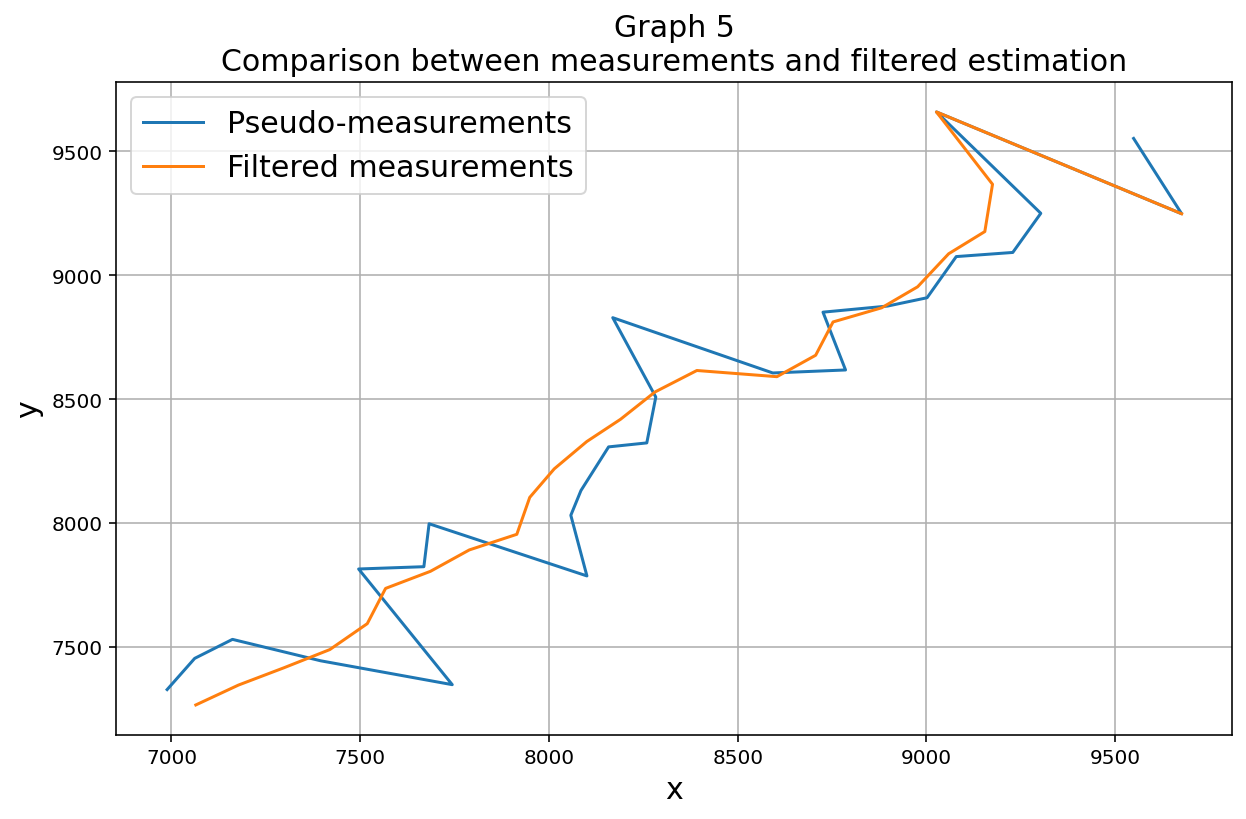

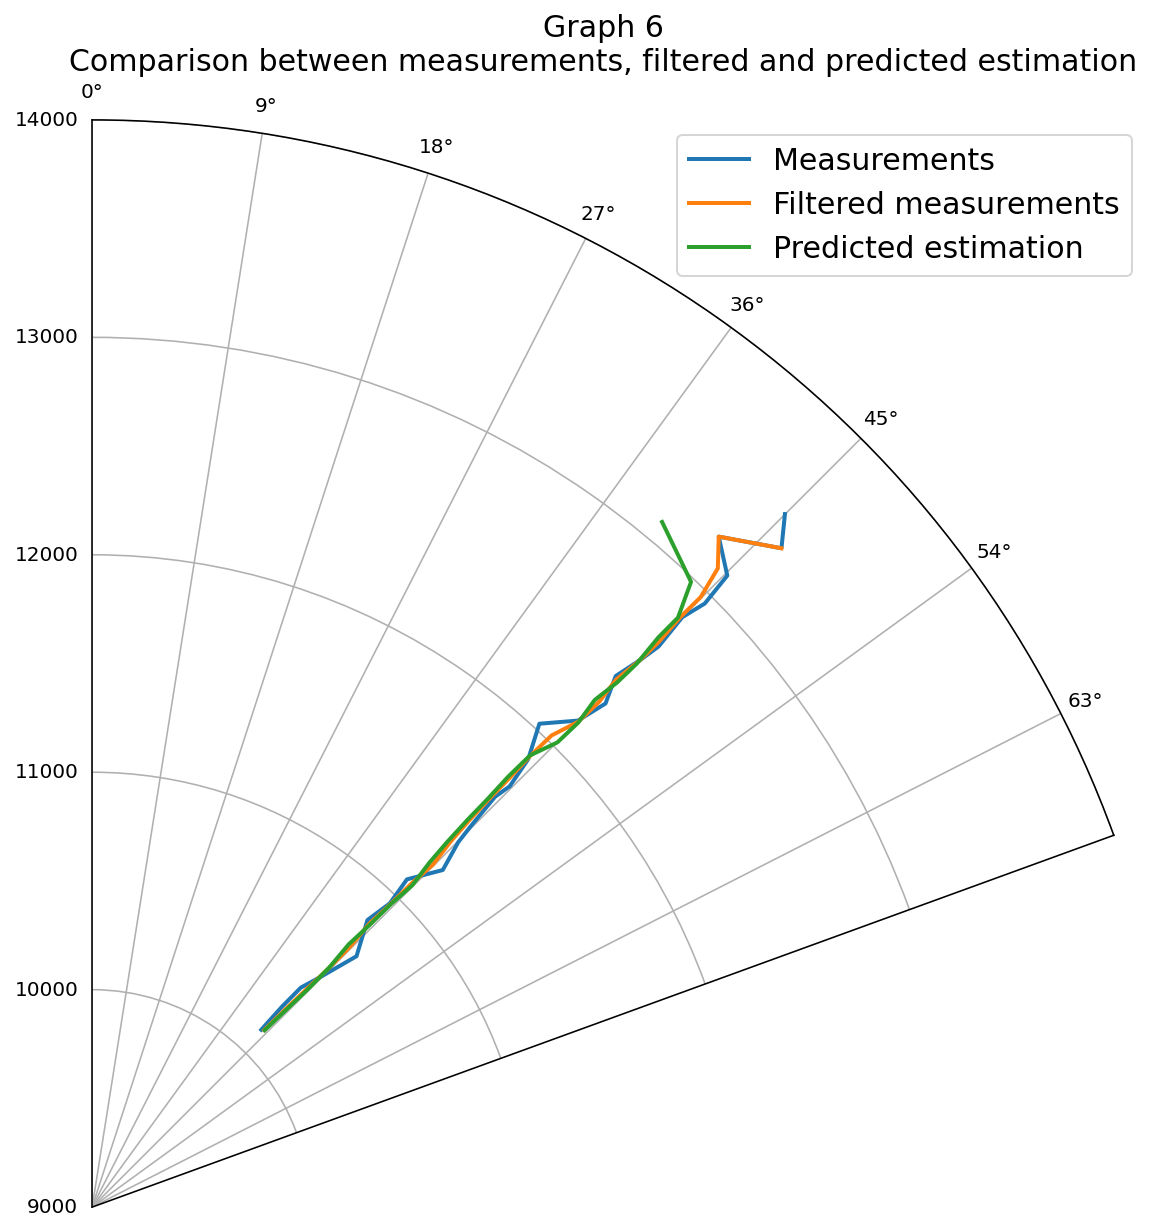

In [20]:
plt.figure(figsize = (10, 6))
plt.plot(Zc[:, 0], Zc[:, 1])
plt.plot(X_filt[0][1:, 0], X_filt[0][1:, 2])
plt.grid()
plt.ylabel('y', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.legend(['Pseudo-measurements','Filtered measurements'], fontsize=15)
plt.title('Graph 5\nComparison between measurements and filtered estimation', fontsize=15)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(9000,14000)
ax.set_xlim([0*(np.pi/180),70*(np.pi/180)])
plt.polar(Dm[:, 1], Dm[:, 0],linewidth=2)
plt.polar(X_filt[1][1:, 1], X_filt[1][1:, 0],linewidth=2)
plt.polar(X_filt[2][3:, 1], X_filt[2][3:, 0],linewidth=2)
plt.legend(['Measurements','Filtered measurements','Predicted estimation'], fontsize=15)
plt.title('Graph 6\nComparison between measurements, filtered and predicted estimation', fontsize=15)

## As we can see from graph 6, predicted estimations are further from filtered estimates but still quite close to the form of graph of measurements.

### 10. Calculating true errors of estimation 

In [21]:
final_err = prob(x0, y0, Vx, Vy, T, N, sigma_eta_D, sigma_eta_b, X0, P0, F, Q, H)

Text(0.5, 1.0, 'Graph 7\nTrue estimation errors of range D')

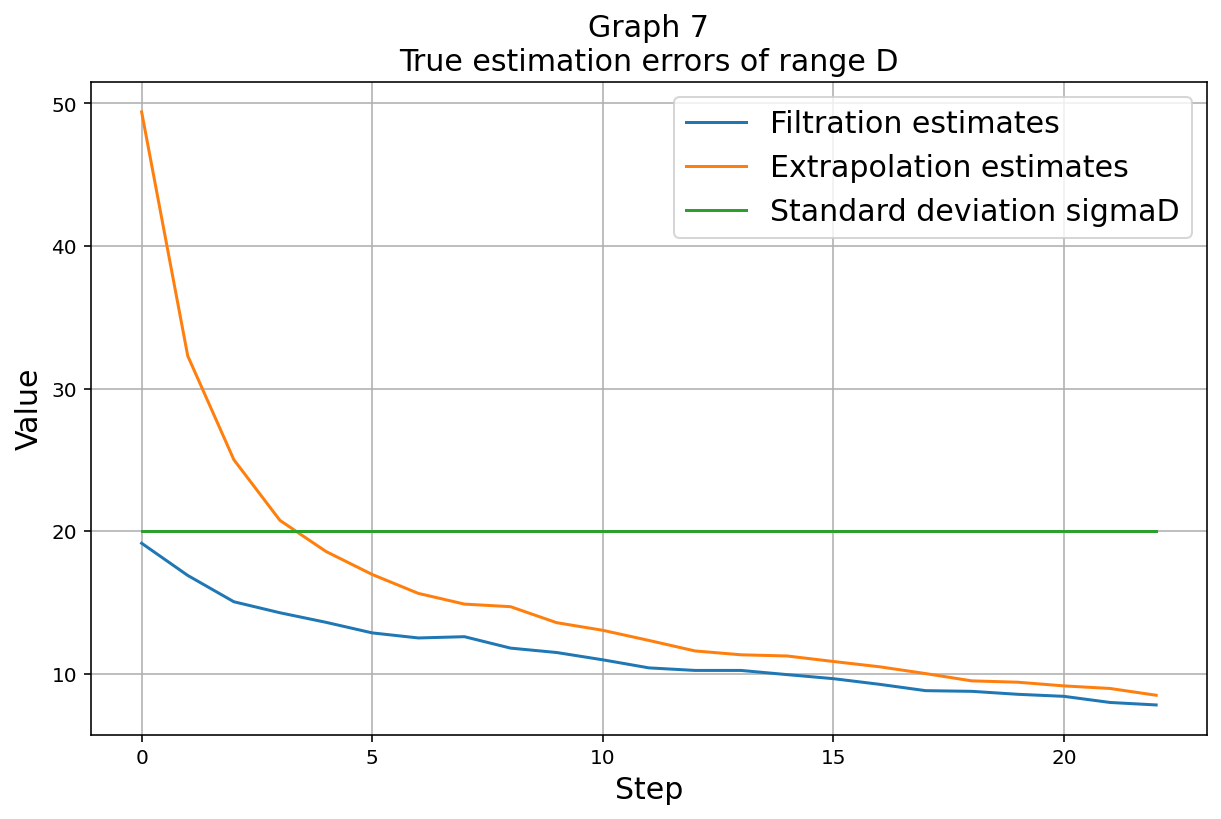

In [22]:
plt.figure(figsize = (10, 6))
plt.plot(final_err[:, 0])
plt.plot(final_err[:, 2])
plt.plot(np.ones(len(final_err[:, 0])) * sigma_eta_D)
plt.grid()
plt.ylabel('Value', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(['Filtration estimates','Extrapolation estimates', 'Standard deviation sigmaD'], fontsize=15)
plt.title('Graph 7\nTrue estimation errors of range D', fontsize=15)

Text(0.5, 1.0, 'Graph 8\nTrue estimation errors of range Beta')

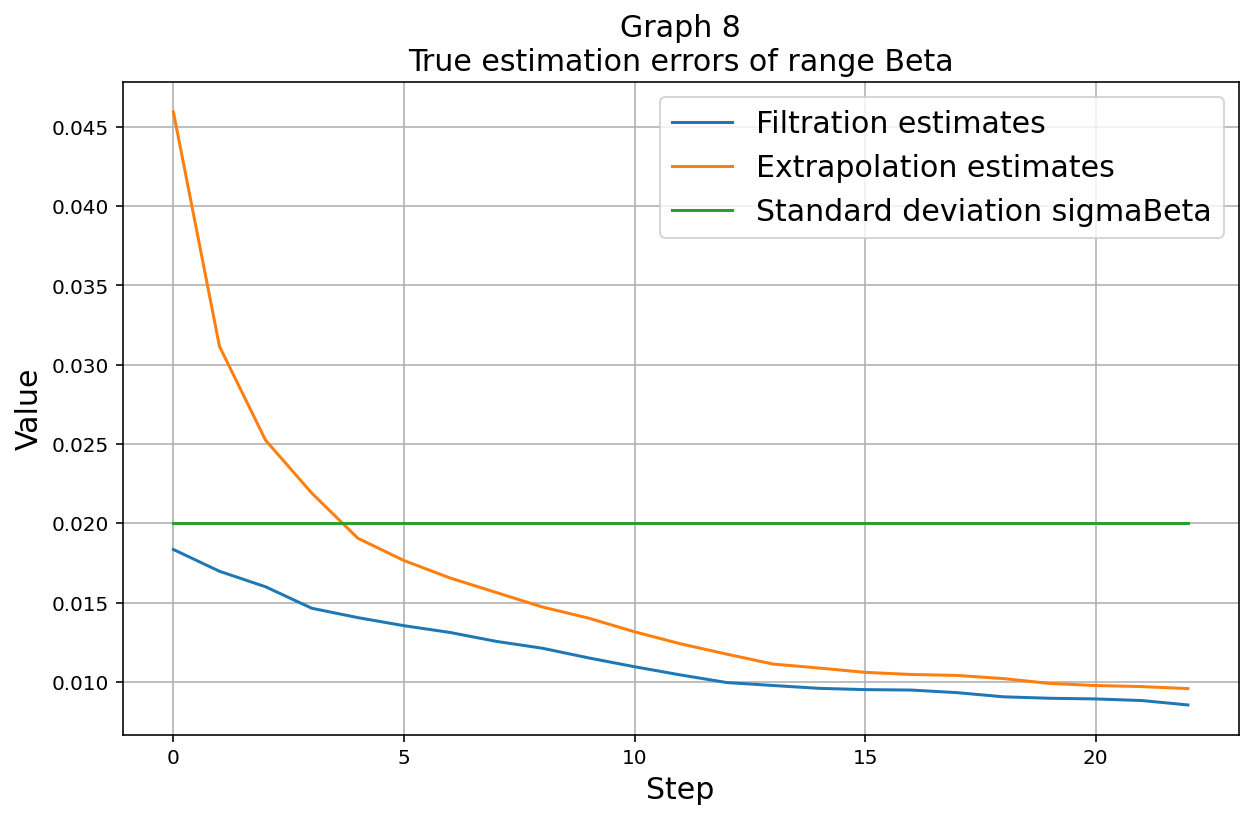

In [23]:
plt.figure(figsize = (10, 6))
plt.plot(final_err[:, 1])
plt.plot(final_err[:, 3])
plt.plot(np.ones(len(final_err[:, 0])) * sigma_eta_b)
plt.grid()
plt.ylabel('Value', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(['Filtration estimates','Extrapolation estimates', 'Standard deviation sigmaBeta'], fontsize=15)
plt.title('Graph 8\nTrue estimation errors of range Beta', fontsize=15)

## Graphs 7 and 8 show that we lay in the required interval for filtration from the first step, and we get errors lower then standard deviation, but only after approximately 4 steps for extrapolated results. Therefore, we can assume that extrapolation could be used as a way for prediction of the next state of the system with error lower than standard deviation measurements after some steps. 

### 11. Analyzing dependence of coordinate x on azimuth Beta

Text(0.5, 1.0, 'Graph 9\nDependence of coordinate x on azimuth Beta')

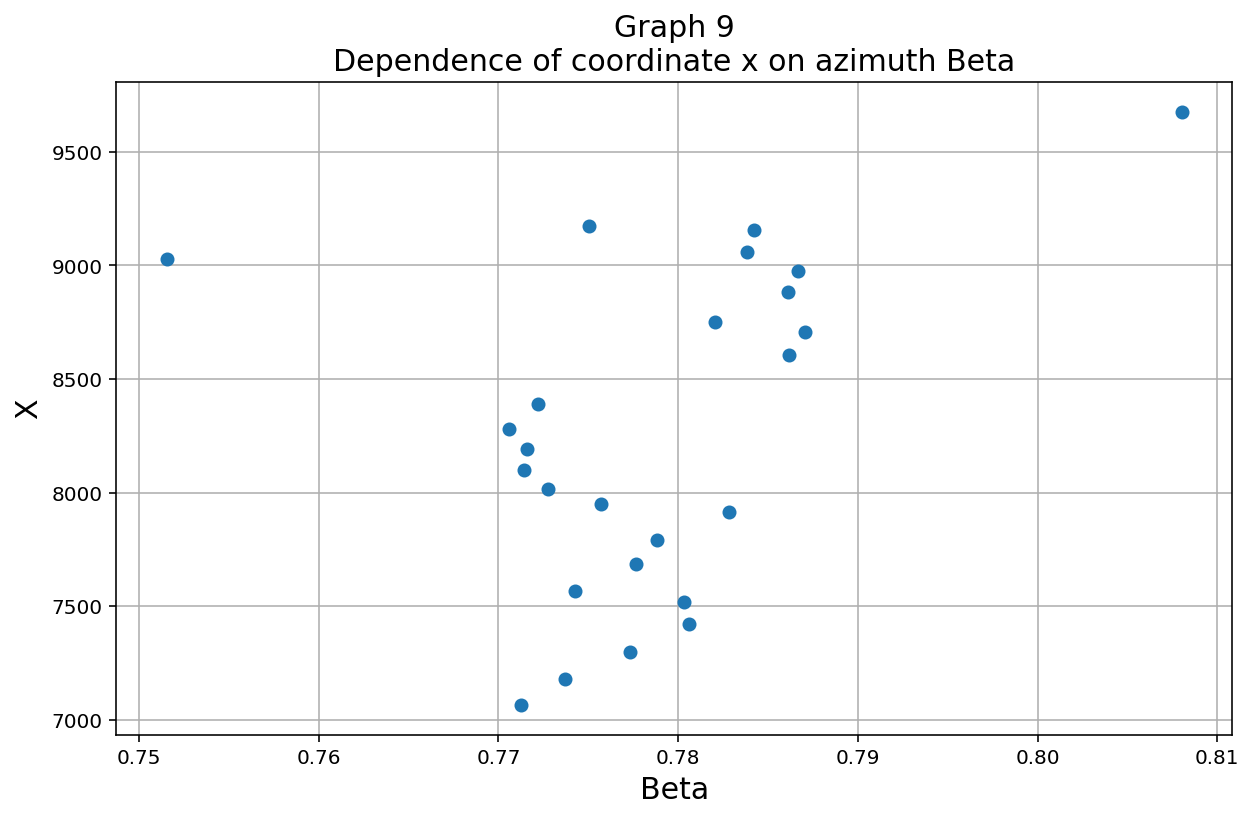

In [24]:
plt.figure(figsize = (10, 6))
plt.plot(X_filt[1][1:,1], X_filt[0][1:, 0],'o')
plt.grid()
plt.ylabel('X', fontsize=15)
plt.xlabel('Beta', fontsize=15)
plt.title('Graph 9\nDependence of coordinate x on azimuth Beta', fontsize=15)

## Here we can see that dependence of coordinate x on azimuth is nonlinear, thus linearization errors in this case are significant. 

### 12. Calculating condition number of covariance matrix R

Text(0.5, 1.0, 'Graph 10\nCondition number')

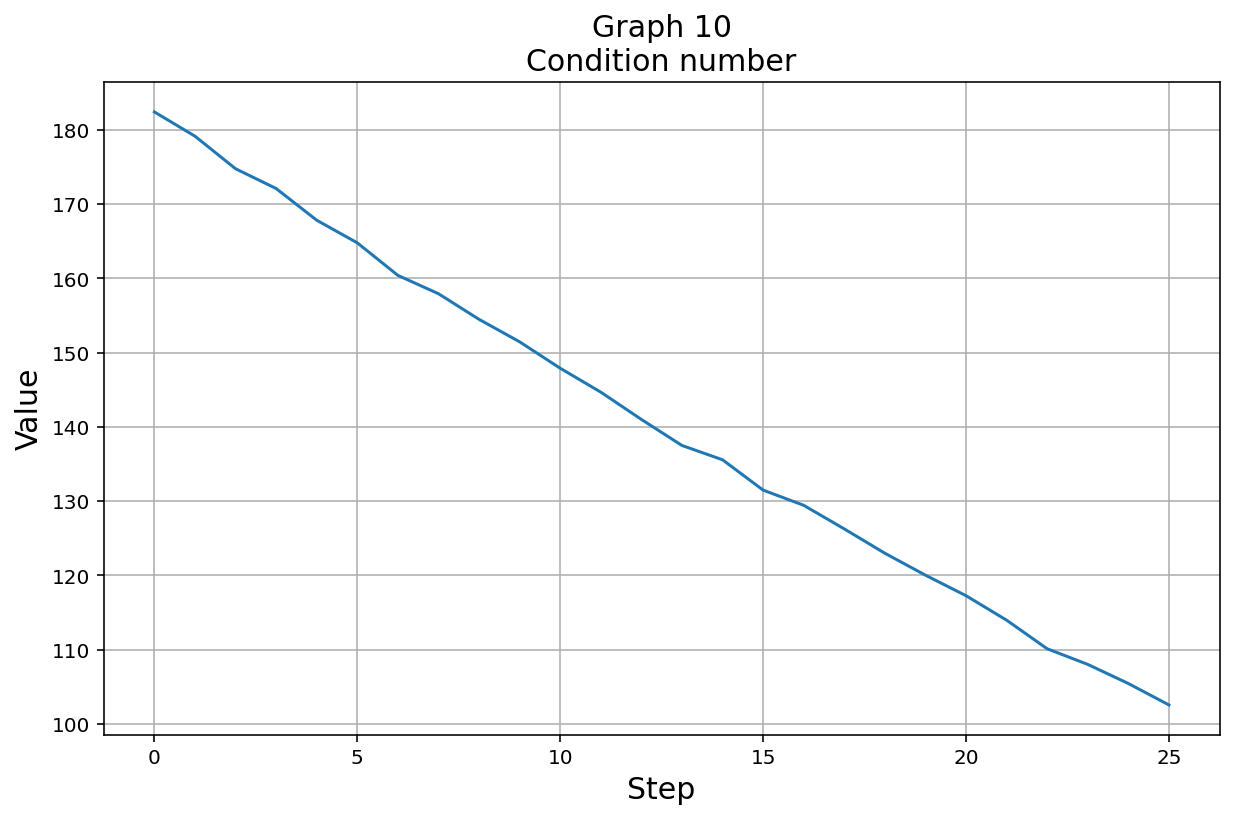

In [25]:
plt.figure(figsize = (10, 6))
plt.plot(condition_number(Dm, sigma_eta_D, sigma_eta_b))
plt.grid()
plt.ylabel('Value', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.title('Graph 10\nCondition number', fontsize=15)

## Graph 10 shows that condition number is smaller then 1000 and only gets lower, therefore, the measurement error covariance matrix R is well-conditioned and we have rather accurate estimation.

### 13. Analyzing filter gain K

Text(0.5, 1.0, 'Graph 11\nFilter gain K')

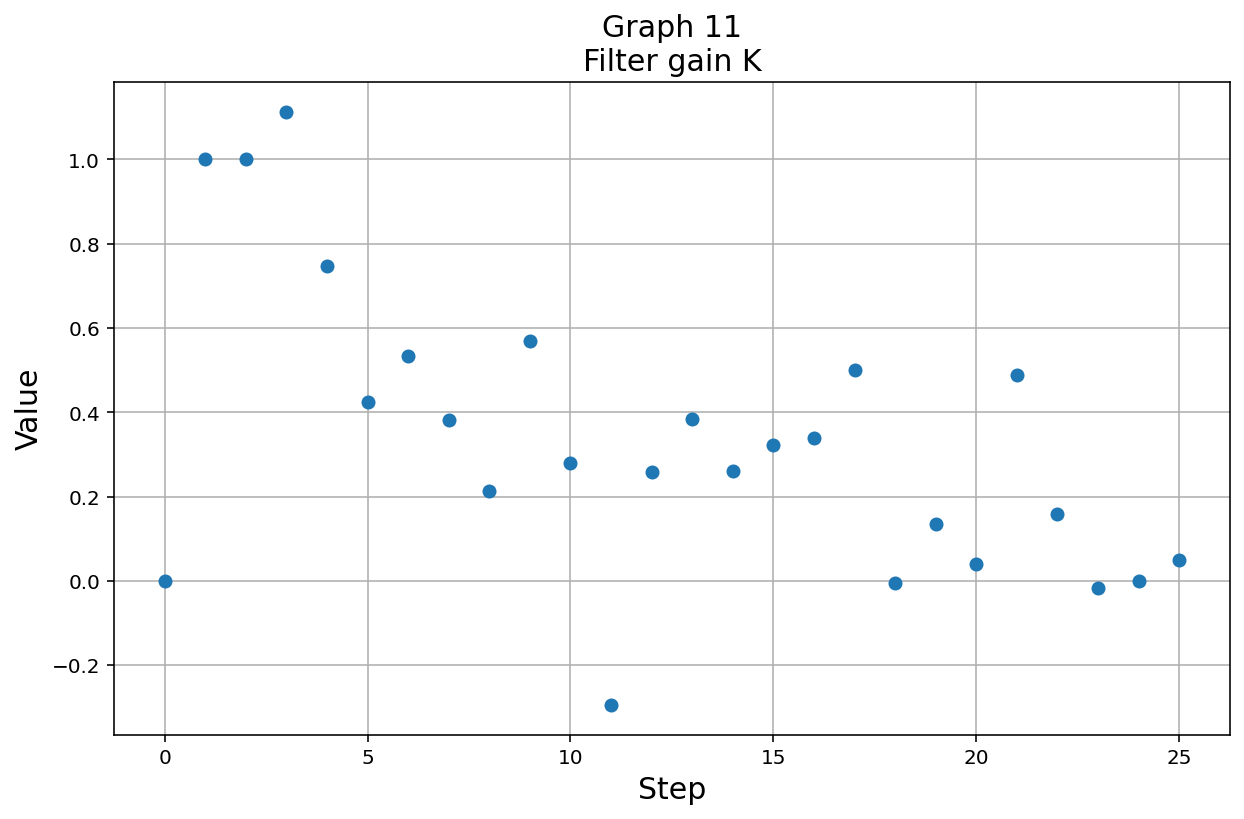

In [26]:
plt.figure(figsize = (10, 6))
plt.plot(X_filt[-1][:, 0, 0], 'o')
plt.grid()
plt.ylabel('Value', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.title('Graph 11\nFilter gain K', fontsize=15)

## Filter gain K is steading with increasing amount of steps.

### 14.  Applying Kalman filter algorithm with other initial conditions 

In [27]:
x0 = 3500 / (2 ** 0.5)
y0 = 3500 / (2 ** 0.5)
Zc, Dm, R = generate_z(x0, y0, Vx, Vy, T, N, sigma_eta_D, sigma_eta_b)
X_filt = kalman_filt(Zc, X0, P0, F, Q, R, H)
final_err1 = prob(x0, y0, Vx, Vy, T, N, sigma_eta_D, sigma_eta_b, X0, P0, F, Q, H)

Text(0.5, 1.0, 'Graph 13\nComparison between measurements, filtered and predicted estimation')

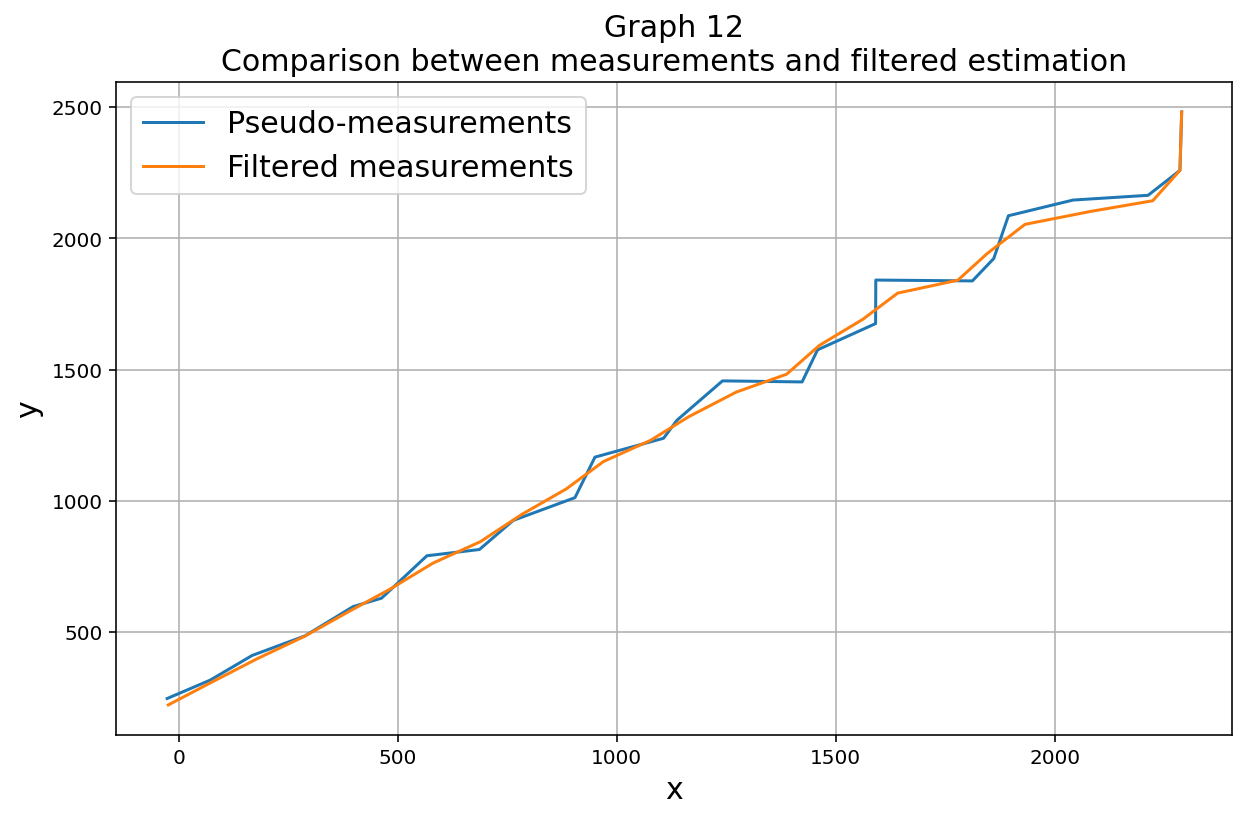

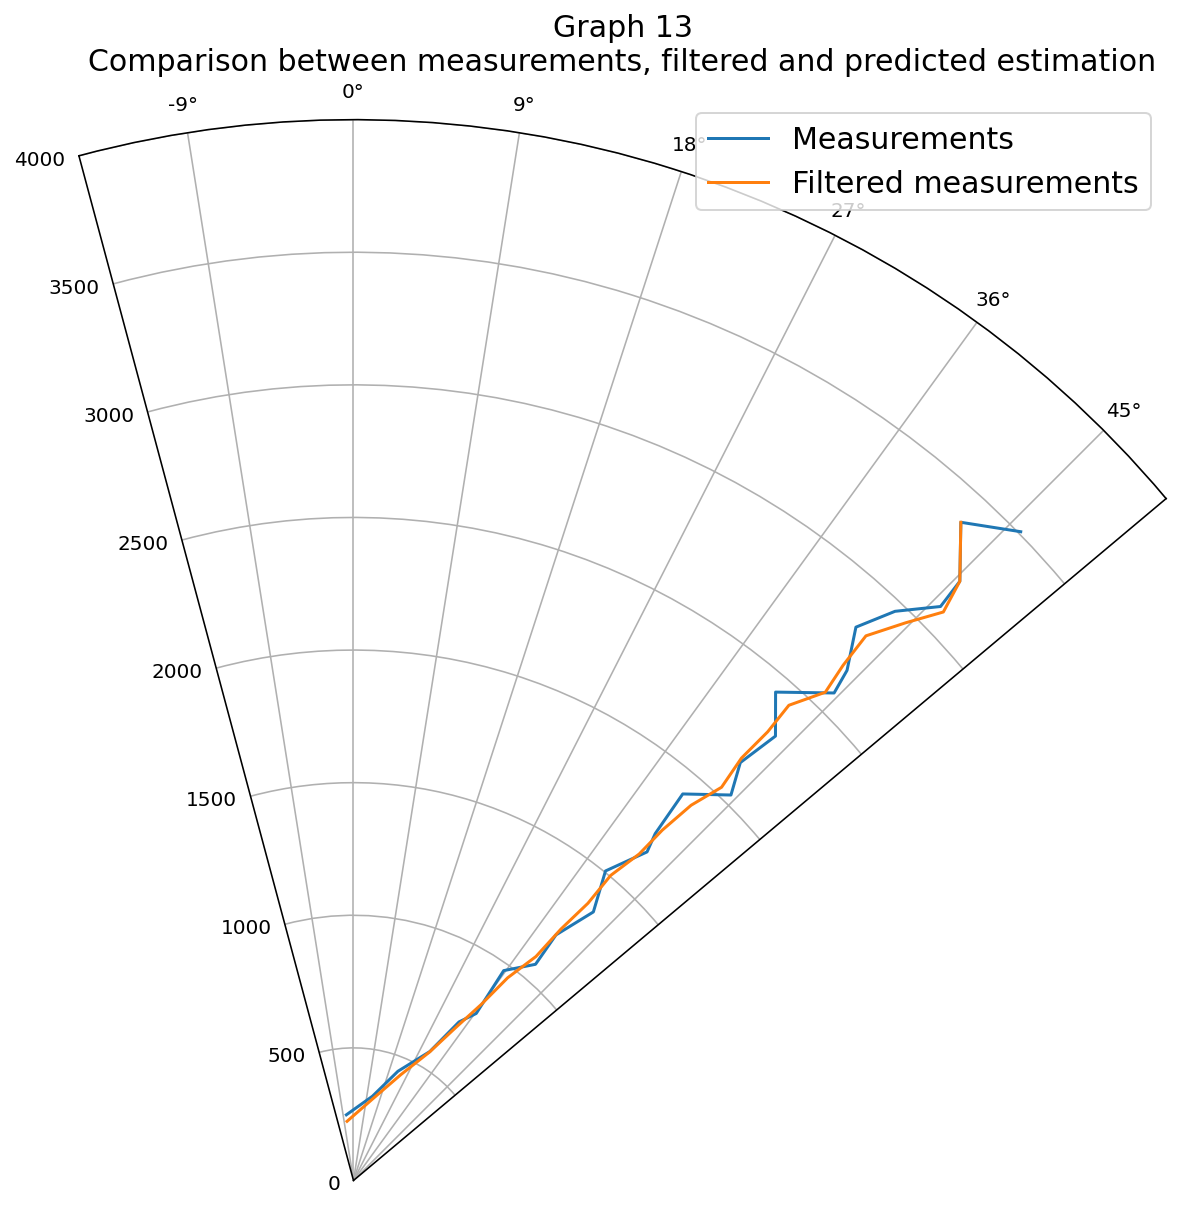

In [28]:
plt.figure(figsize = (10, 6))
plt.plot(Zc[1:, 0], Zc[1:, 1])
plt.plot(X_filt[0][1:, 0], X_filt[0][1:, 2])
plt.grid()
plt.ylabel('y', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.legend(['Pseudo-measurements','Filtered measurements'], fontsize=15)
plt.title('Graph 12\nComparison between measurements and filtered estimation', fontsize=15)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.polar(Dm[:, 1], Dm[:, 0])
plt.polar(X_filt[1][1:, 1], X_filt[1][1:, 0])
ax.set_rlim(0,4000)
ax.set_xlim([-15*(np.pi/180),50*(np.pi/180)])
plt.legend(['Measurements','Filtered measurements','Predicted estimation'], fontsize=15)
plt.title('Graph 13\nComparison between measurements, filtered and predicted estimation', fontsize=15)

### 15. Calculating true errors of estimation with other initial conditions 

Text(0.5, 1.0, 'Graph 14\nTrue estimation errors of range D')

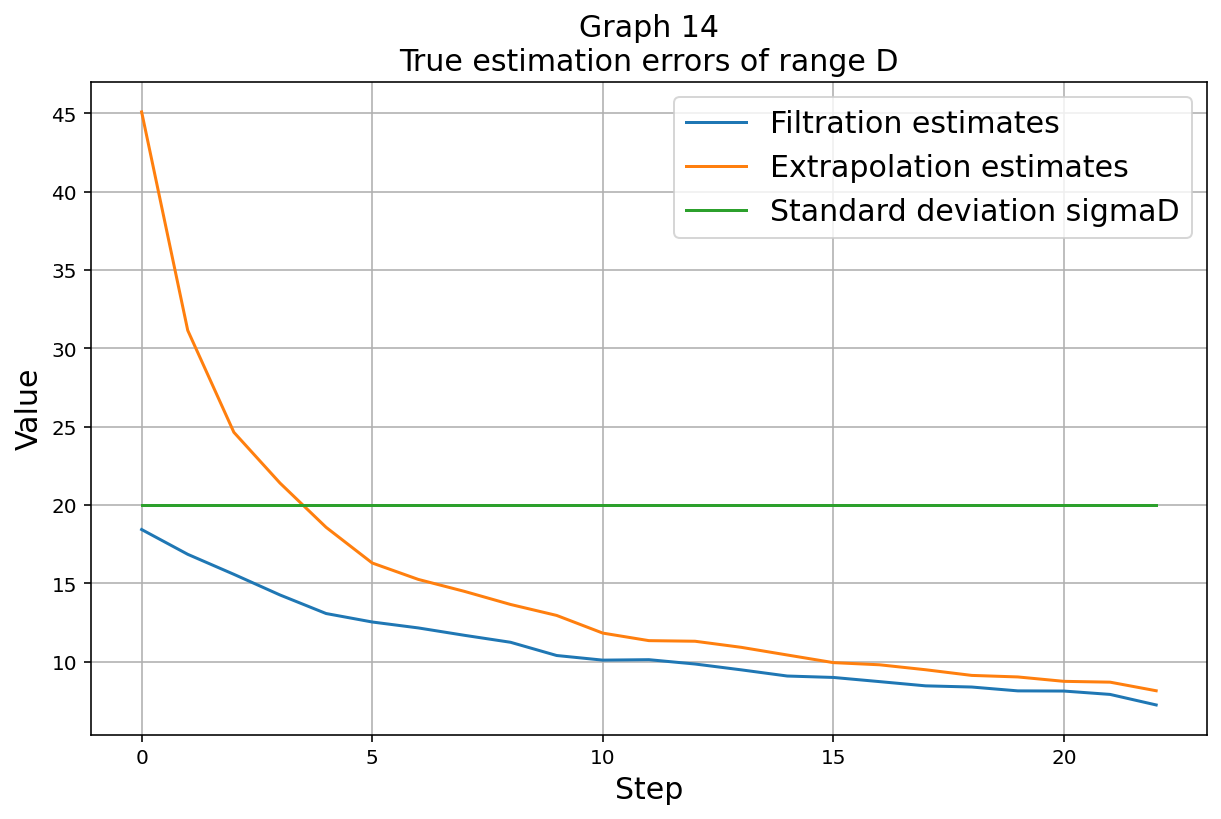

In [29]:
plt.figure(figsize = (10, 6))
plt.plot(final_err1[:, 0])
plt.plot(final_err1[:, 2])
plt.plot(np.ones(len(final_err1[:, 0])) * sigma_eta_D)
plt.grid()
plt.ylabel('Value', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(['Filtration estimates','Extrapolation estimates', 'Standard deviation sigmaD'], fontsize=15)
plt.title('Graph 14\nTrue estimation errors of range D', fontsize=15)

Text(0.5, 1.0, 'Graph 15\nTrue estimation errors of range Beta')

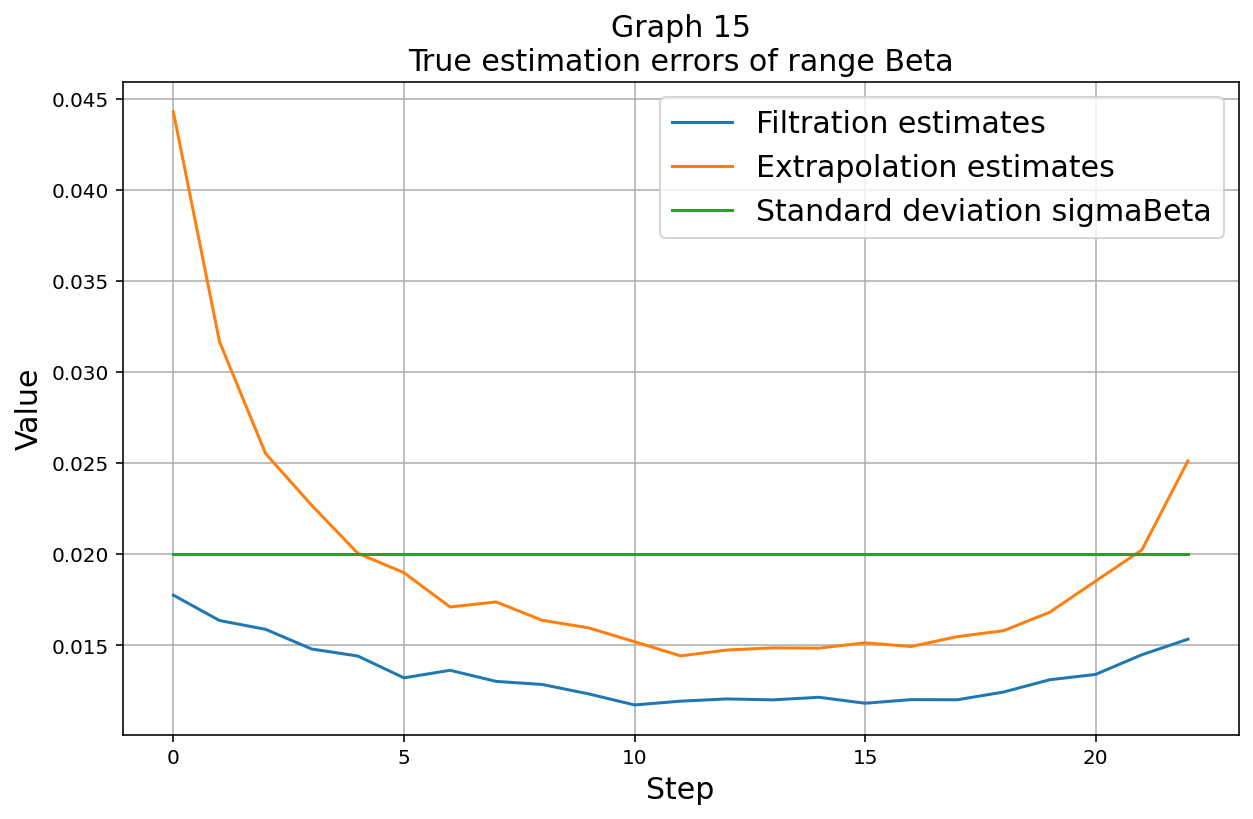

In [30]:
plt.figure(figsize = (10, 6))
plt.plot(final_err1[:, 1])
plt.plot(final_err1[:, 3])
plt.plot(np.ones(len(final_err1[:, 0])) * sigma_eta_b)
plt.grid()
plt.ylabel('Value', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(['Filtration estimates','Extrapolation estimates', 'Standard deviation sigmaBeta'], fontsize=15)
plt.title('Graph 15\nTrue estimation errors of range Beta', fontsize=15)

### 16. Analyzing dependence of coordinate x on azimuth Beta with other initial conditions 

Text(0.5, 1.0, 'Graph 16\nDependence of coordinate x on azimuth Beta')

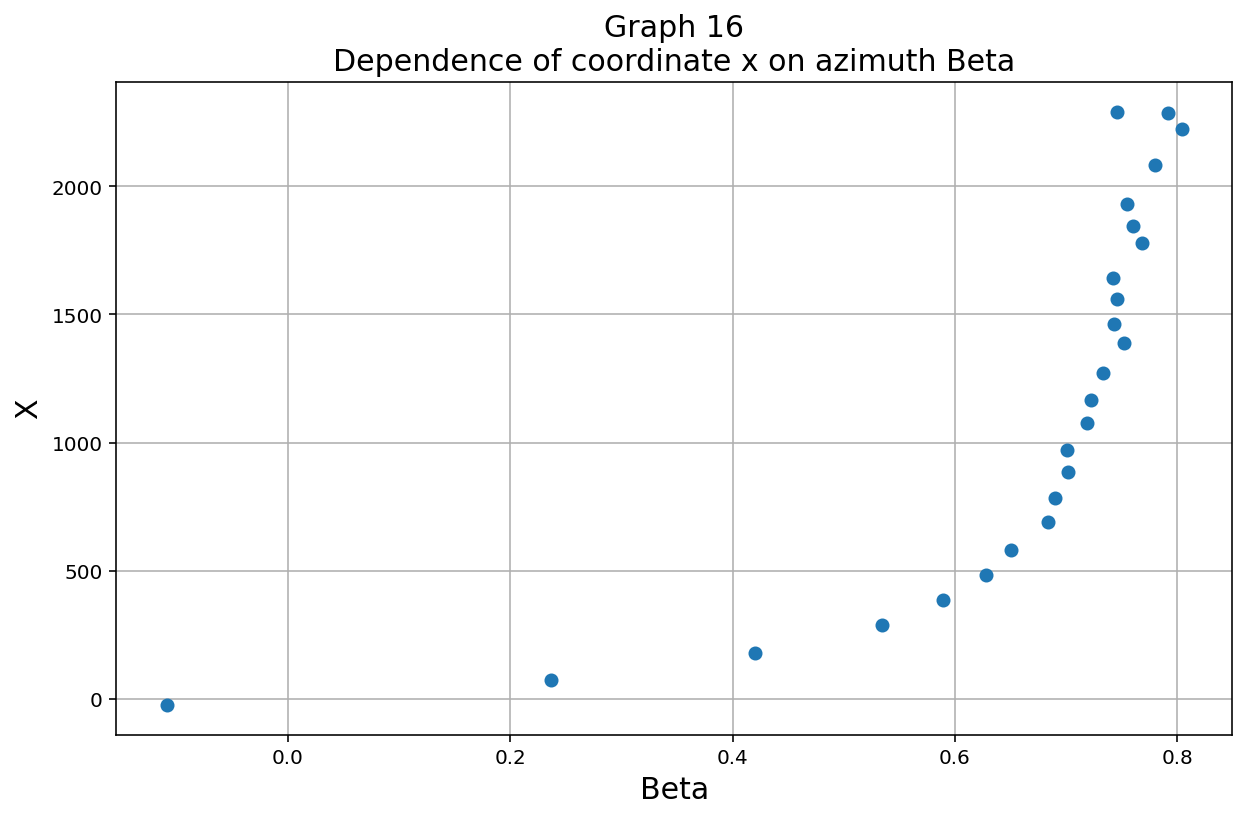

In [31]:
plt.figure(figsize = (10, 6))
plt.plot(X_filt[1][1:,1], X_filt[0][1:, 0], 'o')
plt.grid()
plt.ylabel('X', fontsize=15)
plt.xlabel('Beta', fontsize=15)
plt.title('Graph 16\nDependence of coordinate x on azimuth Beta', fontsize=15)

### 17. Calculating condition number of covariance matrix R with other initial conditions  

Text(0.5, 1.0, 'Graph 17\nCondition number')

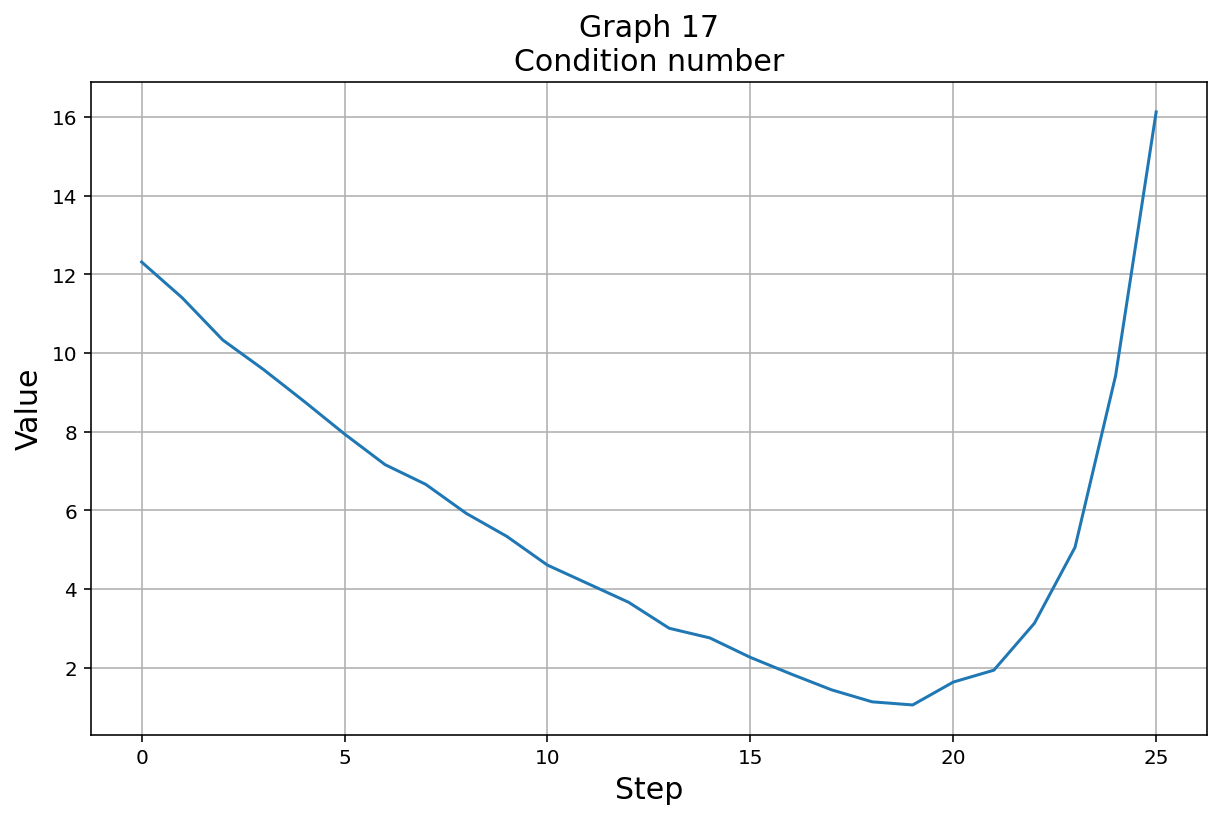

In [32]:
plt.figure(figsize = (10, 6))
plt.plot(condition_number(Dm, sigma_eta_D, sigma_eta_b))
plt.grid()
plt.ylabel('Value', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.title('Graph 17\nCondition number', fontsize=15)

### 18. As we have such initial conditions that an object starts its motion at a quite close distance from an observer, then changes in Beta range are playing bigger role then they did before, when the starting point of motion was far apart. That can be seen from estimation errors of range Beta (graph 15): firstly errors are getting lower with increasing amount of measurements but when we get closer to the observation point, even small changes in Beta are quite crucial. Also such a conclusion can be made from graphs 16 and 17, as dependence of coordinate x on azimuth Beta is nonlinear and linearization errors are significant, also condition number is getting lower but at some point, when we get too close to the observer, it starts growing rapidly. 
## Thus starting position of a moving object is of big importantance for tracking accuracy. 

### 19. Running filter again with other standard deviations 

In [33]:
sigma_eta_D, sigma_eta_b = 50, 0.0015
Zc, Dm, R = generate_z(x0, y0, Vx, Vy, T, N, sigma_eta_D, sigma_eta_b)
X_filt = kalman_filt(Zc, X0, P0, F, Q, R, H)
final_err2 = prob(x0, y0, Vx, Vy, T, N, sigma_eta_D, sigma_eta_b, X0, P0, F, Q, H)

Text(0.5, 1.0, 'Graph 19\nComparison between measurements, filtered and predicted estimation')

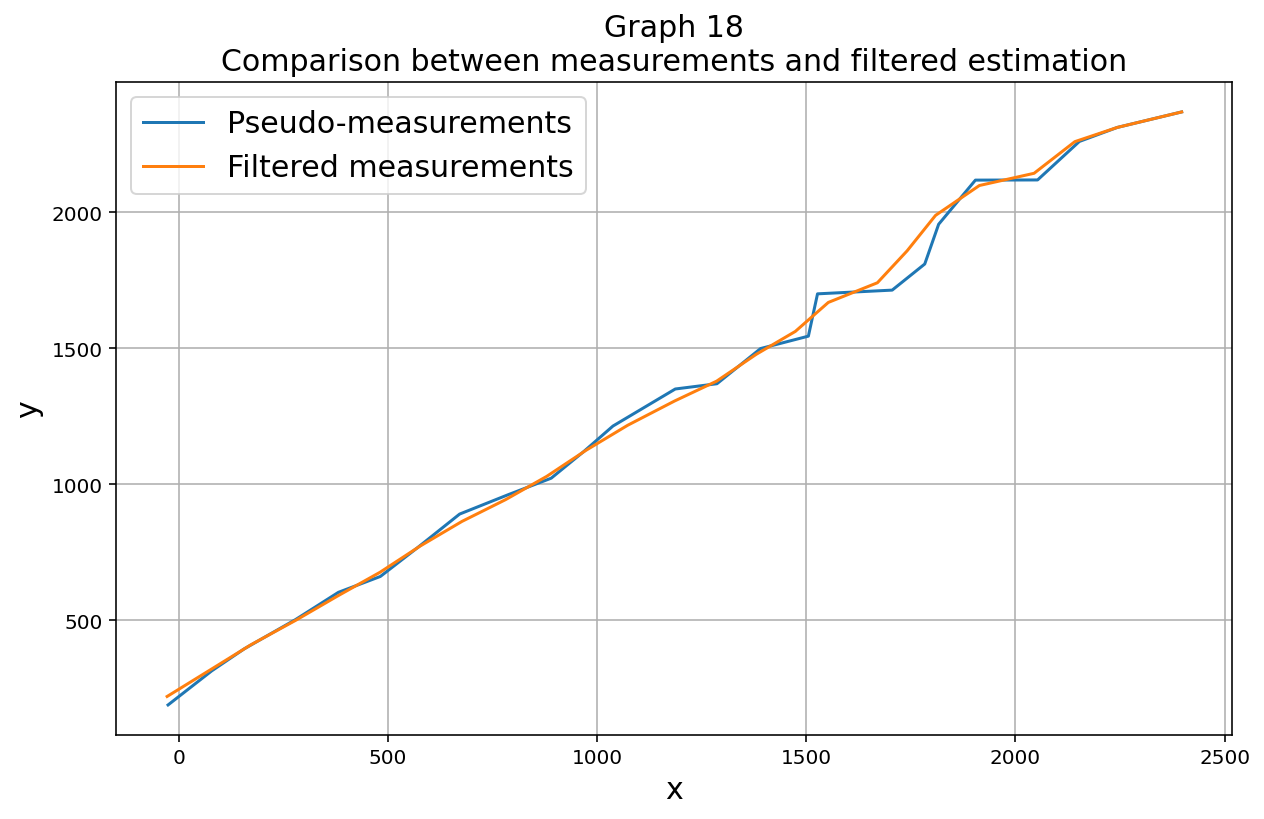

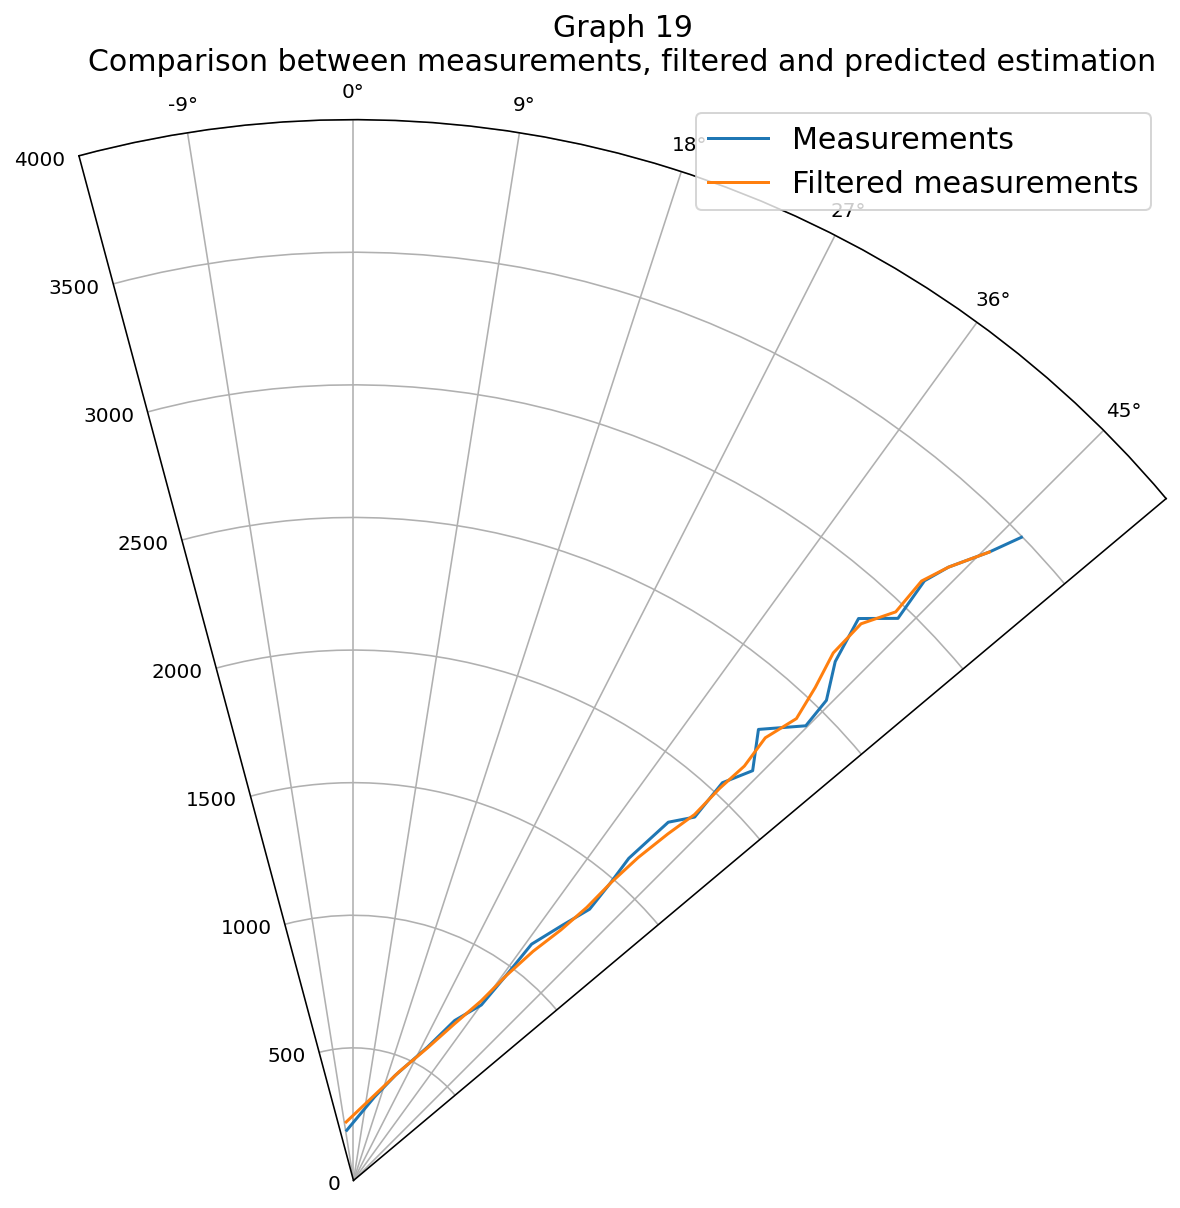

In [34]:
plt.figure(figsize = (10, 6))
plt.plot(Zc[1:, 0], Zc[1:, 1])
plt.plot(X_filt[0][1:, 0], X_filt[0][1:, 2])
plt.grid()
plt.ylabel('y', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.legend(['Pseudo-measurements','Filtered measurements'], fontsize=15)
plt.title('Graph 18\nComparison between measurements and filtered estimation', fontsize=15)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.polar(Dm[:, 1], Dm[:, 0])
plt.polar(X_filt[1][1:, 1], X_filt[1][1:, 0])
ax.set_rlim(0,4000)
ax.set_xlim([-15*(np.pi/180),50*(np.pi/180)])
plt.legend(['Measurements','Filtered measurements','Predicted estimation'], fontsize=15)
plt.title('Graph 19\nComparison between measurements, filtered and predicted estimation', fontsize=15)

Text(0.5, 1.0, 'Graph 20\nTrue estimation errors of range D')

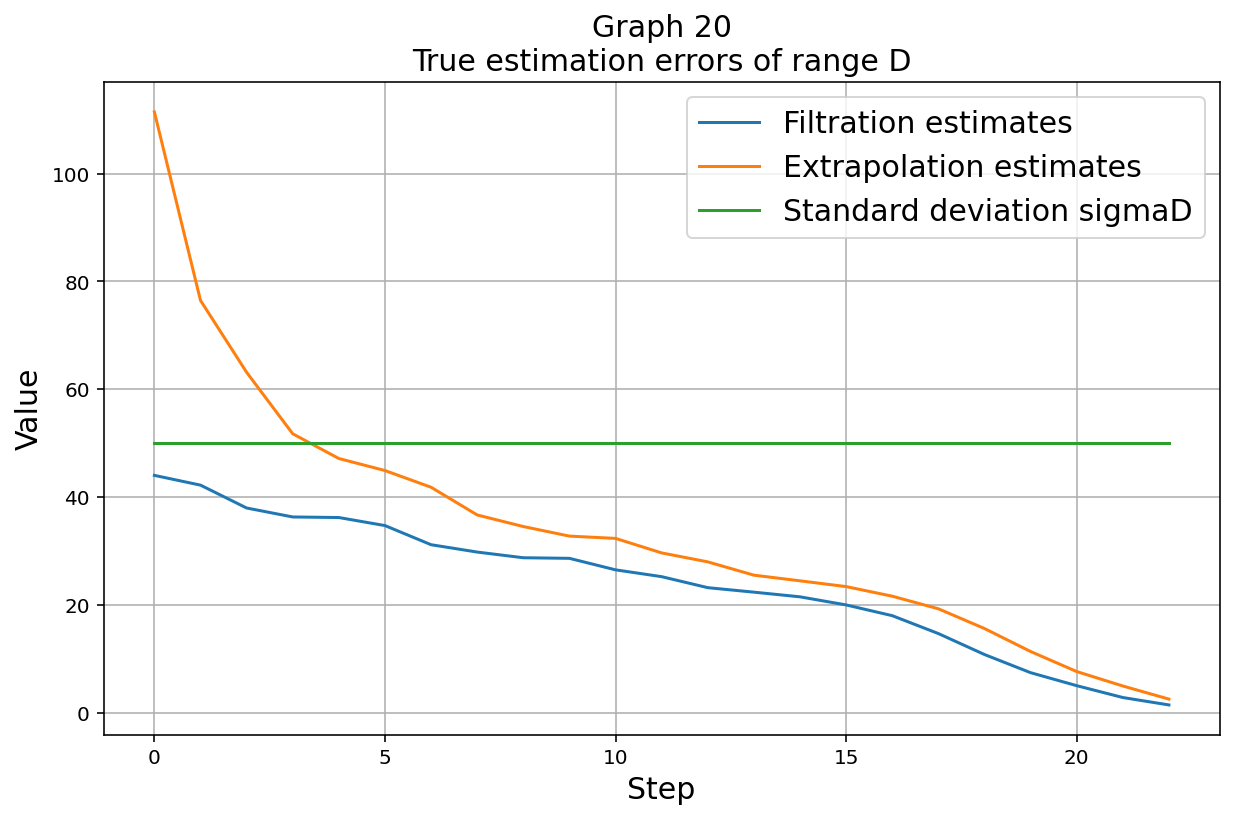

In [35]:
plt.figure(figsize = (10, 6))
plt.plot(final_err2[:, 0])
plt.plot(final_err2[:, 2])
plt.plot(np.ones(len(final_err2[:, 0])) * sigma_eta_D)
plt.grid()
plt.ylabel('Value', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(['Filtration estimates','Extrapolation estimates', 'Standard deviation sigmaD'], fontsize=15)
plt.title('Graph 20\nTrue estimation errors of range D', fontsize=15)

Text(0.5, 1.0, 'Graph 21\nTrue estimation errors of range Beta')

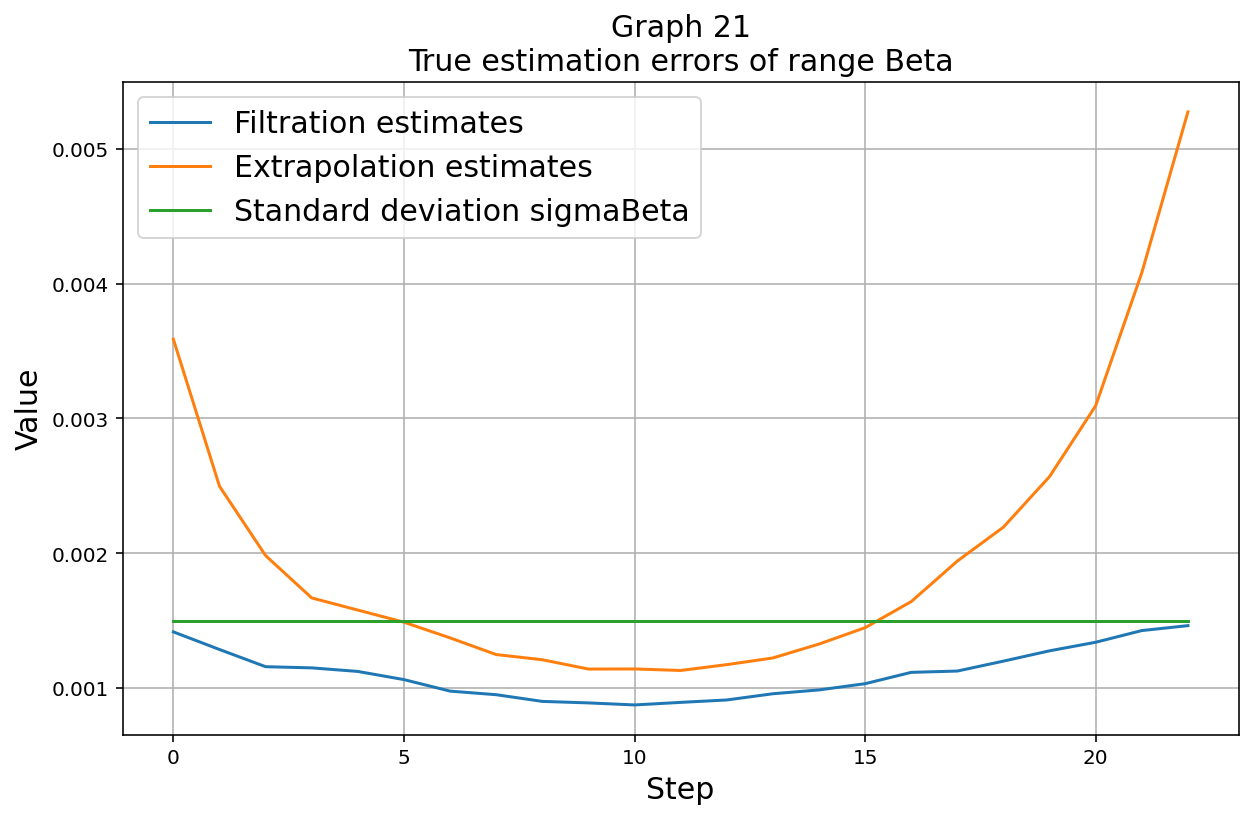

In [36]:
plt.figure(figsize = (10, 6))
plt.plot(final_err2[:, 1])
plt.plot(final_err2[:, 3])
plt.plot(np.ones(len(final_err2[:, 0])) * sigma_eta_b)
plt.grid()
plt.ylabel('Value', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(['Filtration estimates','Extrapolation estimates', 'Standard deviation sigmaBeta'], fontsize=15)
plt.title('Graph 21\nTrue estimation errors of range Beta', fontsize=15)

Text(0.5, 1.0, 'Graph 22\nDependence of coordinate x on azimuth Beta')

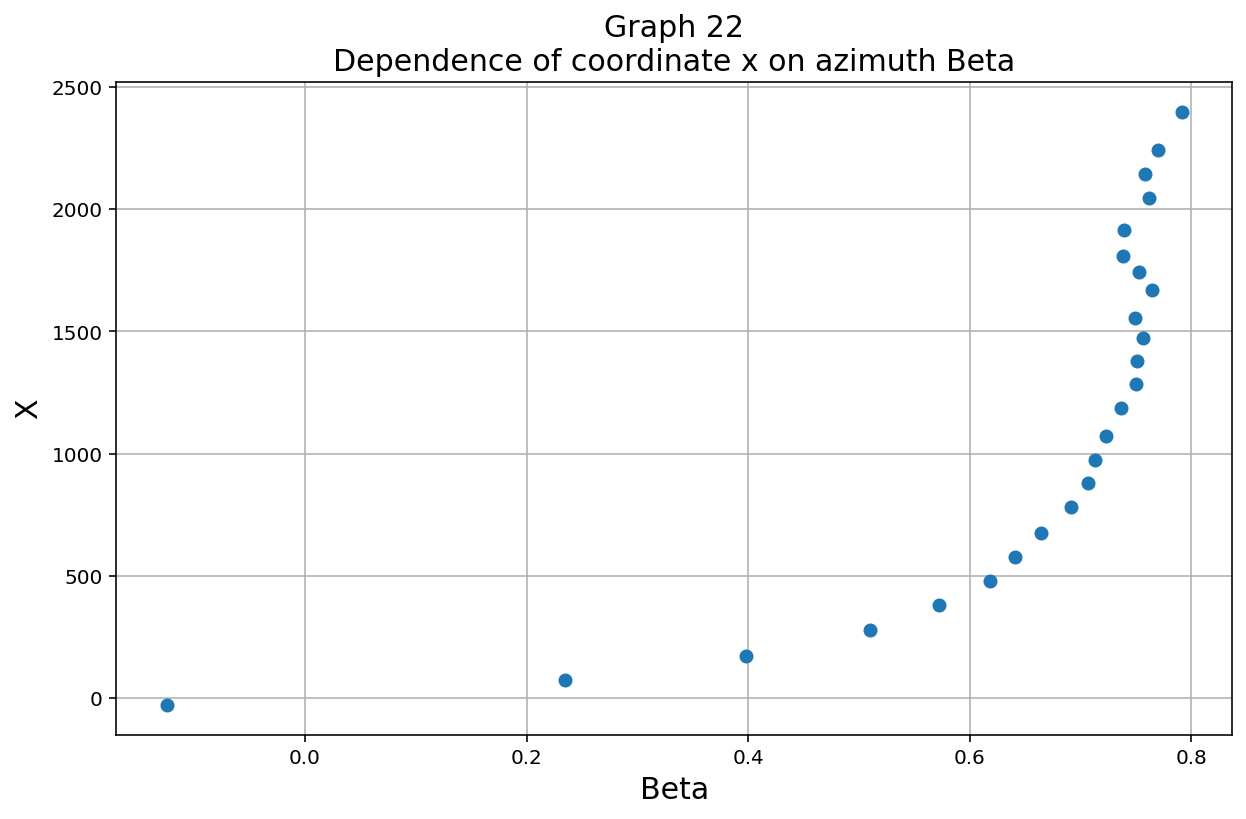

In [37]:
plt.figure(figsize = (10, 6))
plt.plot(X_filt[1][1:,1], X_filt[0][1:, 0], 'o')
plt.grid()
plt.ylabel('X', fontsize=15)
plt.xlabel('Beta', fontsize=15)
plt.title('Graph 22\nDependence of coordinate x on azimuth Beta', fontsize=15)

Text(0.5, 1.0, 'Graph 23\nCondition number')

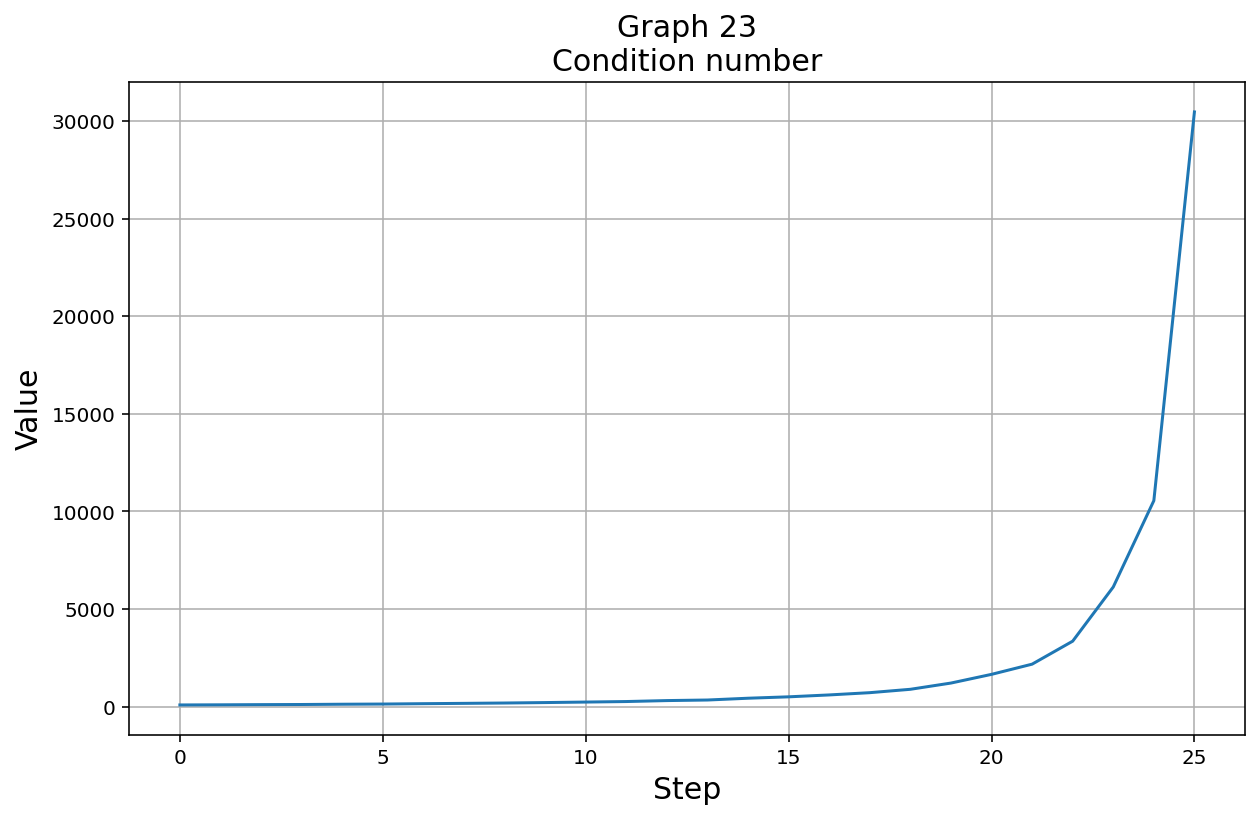

In [48]:
plt.figure(figsize = (10, 6))
plt.plot(condition_number(Dm, sigma_eta_D, sigma_eta_b))
plt.grid()
plt.ylabel('Value', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.title('Graph 23\nCondition number', fontsize=15)

## By analysing graphs above for lower variance of measurement noises Beta but bigger variance of measurement noises D, we can see that we get ill-conditioned matrix R and inaccurate results as well. Again, when we are close to the observation point, then low D and big sigmaD combined give us an enormous condition number. 

### 21. Final conclusions about conditions in which navigation system may become blind and filter may diverge are the following: 
### When we are observing system from a rather far distance, then variances of measurement noises are having less importance then in the opposite situation. Here linearization errors playing bigger role.
### When we are close to the observation point but have a big variances of measurement noises, then we are dealing with ill-conditioned problem. 

## Learning log

### Setting functions was Vladimir Berman's part, as well as applying tracking filter of a moving object when the object is far from the observing point. The conslusion about the importance of linearization was made.  
### Describing sutiation with close observation point and same variances of measurement noises was Artem Bazhenov's task. Here was decided that variances of measurement noises are playing bigger role then before. 
### Scenario with close observation point and bigger variance of measurement noises D was Maria Dronova's part. There we can see that due to bigger variance of measurement noise D and closer observing point we are getting  ill-conditioned matrix R and inaccurate results, i.e., our navigation system becomes blind. 